In [1]:
import torch
import os 
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import unpack_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import matplotlib.pyplot as plt
%run ~/violin-renderer/src/data/parse_data.ipynb
%run ~/violin-renderer/src/models/lstm/data_processing.ipynb

In [2]:
HOME_DIR = os.path.expanduser("~")

In [3]:
# initialize GPU to move model/tensors onto
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [4]:
class LSTMMusicDataset(Dataset):
    def __init__(self, input_data, ground_truth, transform=None):
        self.input_data = input_data
        self.ground_truth = ground_truth
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        input_sample = self.input_data[idx]
        ground_truth_sample = self.ground_truth[idx]

        if self.transform:
            input_sample = self.transform(input_sample)

        return input_sample, ground_truth_sample

In [5]:
training_source_inputs, training_ground_truths = processed_training_data()
validate_source_inputs, validate_ground_truths = processed_validating_data()

In [6]:
training_data = LSTMMusicDataset(input_data=training_source_inputs, ground_truth=training_ground_truths)
validate_data = LSTMMusicDataset(input_data=validate_source_inputs, ground_truth=validate_ground_truths)

In [7]:
class PadSequence:
    def __call__(self, batch):
        # conversion into tensors
        sequences = [torch.tensor(x[0]) for x in batch]
		# Get each sequence and pad it
        sequences_padded = pad_sequence(sequences, batch_first=True)
		# Store length of each sequence
        lengths = torch.LongTensor([len(x[0]) for x in batch])
        # Also convert ground truths to tensors
        ground_truth = [torch.tensor(x[1]) for x in batch]
        return sequences_padded, lengths, ground_truth

In [8]:
training_loader = DataLoader(training_data, batch_size=4, shuffle=True, collate_fn=PadSequence())
validate_loader = DataLoader(validate_data, batch_size=4, shuffle=False, collate_fn=PadSequence())

In [9]:
# reference: https://www.kaggle.com/code/kanncaa1/long-short-term-memory-with-pytorch
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, bidirectional=True, batch_first=True) # batch_first=True (batch_dim, seq_dim, feature_dim)

        # Output layer
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, input_data, lengths):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, input_data.size(0), self.hidden_dim, device=input_data.device).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, input_data.size(0), self.hidden_dim, device=input_data.device).requires_grad_()

        # Make the model "understand" that we're using padding
        packed_input = pack_padded_sequence(input_data, lengths.cpu().numpy(), batch_first=True, enforce_sorted=False)

        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = self.fc(output)
        
        return output

In [10]:
input_dim = 3
hidden_dim = 32
layer_dim = 2
output_dim = 2

# initialize the MLP
model = LSTM(input_dim, hidden_dim, layer_dim, output_dim)

# transfer model to GPU
model.to(device)

LSTM(
  (lstm): LSTM(3, 32, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [11]:
# Define our loss function (mean squared error) to be used in the grad descent step
loss = nn.MSELoss()

# Performs the gradient descent steps
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Initialize the scheduler (will decrease our learning rate until a predefined number of epochs)
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=1e-3, total_iters=1000)

In [12]:
# @param model The model object to be trained
# @param optimizer The optimizing equation to use to train the model
# @param dataloader The DataLoader object that contains our inputs and ground truths
# @param loss_module Equation for calculating the difference between generated and actual output
def train_model_loop(model, optimizer, dataloader, loss_module):
    # Set model to training mode
    model.train()
    
    # Training loop  
    for batch, (input_notes, lengths, truth_notes) in enumerate(dataloader):
        input_notes = input_notes.to(device)
        lengths = lengths.to(device)

        # Runs the model on the packed data
        preds = model(input_notes, lengths)

        # Calculates loss
        loss = 0
        for pred, truth in zip(preds, truth_notes):
            truth = truth.to(device)
            loss += loss_module(pred[0:len(truth)], truth)
        # Get average loss over the songs
        # loss /= len(input_notes)
        
        # Perform gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Reset gradients & Update parameters
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()

In [13]:
def validate(model, dataloader, loss_module):

    loss_values = []
    
    with torch.no_grad():
        for batch, (input_notes, lengths, truth_notes) in enumerate(dataloader):
            input_notes = input_notes.to(device)
            lengths = lengths.to(device)
    
            # Runs the model on the packed data
            preds = model(input_notes, lengths)
            
            loss = 0
            # Calculates loss
            for pred, truth in zip(preds, truth_notes):
                truth = truth.to(device)
                loss += loss_module(pred[0:len(truth)], truth)
            # loss /= len(input_notes)
    
            # if loss < 500:
            #     torch.save(model.state_dict(), 'best_lstm.pt')
    
            loss_values.append(loss)
            torch.cuda.empty_cache()
    print(sum(loss_values) / len(loss_values))
    return sum(loss_values) / len(loss_values)

In [14]:
# trains the model using the dataloader
def train_model():
    loss_history = []
    epochs = 2000
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_model_loop(model, optimizer, training_loader, loss)
        loss_history.append(validate(model, validate_loader, loss))
        # start decaying the loss AFTER 1000 epochs
        # if t >= 1000:
        #     scheduler.step()
        if loss_history[-1] < 900:
            torch.save(model.state_dict(), 'best_bilstm.pt')
    torch.save(model.state_dict(), 'bilstm.pt')
                            
    return loss_history

In [17]:
# loss_values = [tensor.item() for tensor in train_model()]

Epoch 1
-------------------------------
tensor(8697.8535, device='cuda:2')
Epoch 2
-------------------------------
tensor(8687.0176, device='cuda:2')
Epoch 3
-------------------------------
tensor(8674.8047, device='cuda:2')
Epoch 4
-------------------------------
tensor(8659.4277, device='cuda:2')
Epoch 5
-------------------------------
tensor(8637.0176, device='cuda:2')
Epoch 6
-------------------------------
tensor(8602.8604, device='cuda:2')
Epoch 7
-------------------------------
tensor(8542.5293, device='cuda:2')
Epoch 8
-------------------------------
tensor(8427.9473, device='cuda:2')
Epoch 9
-------------------------------
tensor(8273.7324, device='cuda:2')
Epoch 10
-------------------------------
tensor(8127.1465, device='cuda:2')
Epoch 11
-------------------------------
tensor(8008.1870, device='cuda:2')
Epoch 12
-------------------------------
tensor(7908.4253, device='cuda:2')
Epoch 13
-------------------------------
tensor(7823.8608, device='cuda:2')
Epoch 14
------------

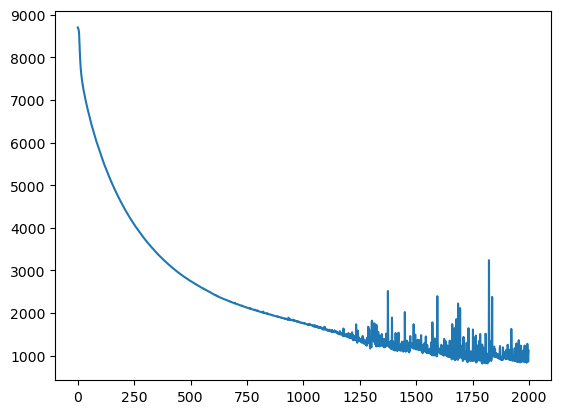

In [18]:
# plt.plot(np.arange(0, len(loss_values)), loss_values)
# plt.show()